# Pathfinding strategies

Pathfinding is a fundamental aspect of artificial intelligence that focuses on finding the optimal route between two points. It's essential in various fields such as robotics, gaming, and logistics. Effective pathfinding algorithms enable agents to navigate through environments efficiently, avoiding obstacles and minimizing travel cost or time.

## Environment Setup

In this notebook, we'll explore different pathfinding algorithms within a grid-based environment:

- **Grid Dimensions**: The environment is a two-dimensional grid with a specified length `L` and height `H`.
- **Tiles**: Each cell in the grid represents a tile, which can be either:
    - **Empty**: The agent can move through these tiles.
    - **Wall**: These are obstacles that the agent cannot pass through.
- **Boundaries**: The outermost rows and columns (first and last of both) are walls, forming the boundaries of the environment.
- **Start Position**: The agent begins at the top-left corner, coordinate `(1, 1)`.
- **Goal Position**: The target is the bottom-right corner, coordinate `(L - 2, H - 2)`.
- **Movement Rules**: The agent can move horizontally or vertically to adjacent tiles (no diagonal movement).

Our goal is to implement and compare various pathfinding algorithms to find the shortest path from the start to the goal while navigating around walls.

Note: In the environment setup code, a "cost" is mentioned. For now, we don't need to worry about the cost of moving between tiles. This concept will be introduced later in the notebook.

Here is the code to set up the environment:

In [1]:
import random
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


class world:
    """
    A class to represent a grid-based world for pathfinding algorithms.

    Attributes:
        L (int): Number of columns in the grid.
        H (int): Number of rows in the grid.
        w (list of int): Grid representation where each tile is empty (0) or a wall (1).
        costs (list of float): Cost of entering each tile.
    """

    def __init__(self, L, H, P):
        self.L = L 
        self.H = H
        self.w = [0 for _ in range(L * H)]

        # Set walls on the boundaries
        for i in range(H):
            self.w[i * L] = 1
            self.w[i * L + L - 1] = 1

        for j in range(L):
            self.w[j] = 1
            self.w[(H - 1) * L + j] = 1

        # Randomly add internal walls
        for i in range(H):
            for j in range(L):
                if (random.random() < P and
                    not (i == 1 and j == 1) and
                    not (i == H - 2 and j == L - 2)):
                    self.w[i * L + j] = 1

        # Initialize costs; walls have infinite cost, others have cost 1
        self.costs = [1 if self.w[i] == 0 else float('inf') for i in range(L * H)]
        
        # Initialize the list to store high-cost regions
        self.high_cost_regions = []

    def set_costs_in_rectangle(self, x1, y1, x2, y2, min_cost=2, max_cost=5):
        """
        Sets random costs greater than min_cost up to max_cost for tiles within the specified rectangle,
        and records the high-cost region boundaries.

        Parameters:
            x1, y1 (int): Coordinates of one corner of the rectangle.
            x2, y2 (int): Coordinates of the opposite corner.
            min_cost (int): Minimum cost for tiles within the rectangle (default 2).
            max_cost (int): Maximum cost for tiles within the rectangle (default 5).
        """
        # Ensure coordinates are within bounds
        x1, x2 = max(0, min(x1, self.L - 1)), max(0, min(x2, self.L - 1))
        y1, y2 = max(0, min(y1, self.H - 1)), max(0, min(y2, self.H - 1))

        # Get the rectangle boundaries
        x_start, x_end = min(x1, x2), max(x1, x2)
        y_start, y_end = min(y1, y2), max(y1, y2)

        # Update tile costs
        for i in range(y_start, y_end + 1):
            for j in range(x_start, x_end + 1):
                tile_index = i * self.L + j
                if self.w[tile_index] == 0:
                    self.costs[tile_index] = random.randint(min_cost, max_cost)
        
        # Record the high-cost region
        self.high_cost_regions.append({
            'x_start': x_start,
            'x_end': x_end,
            'y_start': y_start,
            'y_end': y_end,
            'min_cost': min_cost,
            'max_cost': max_cost
        })
                
    def display(self, path=[], display_costs=False):
        """
        Note: Understanding this method is not required for the assignment as it has been implemented only for visualization purposes.
        
        Displays the grid world with optional path and costs overlay.

        Parameters:
            path (list of int): List of tile indices representing the path to overlay.
            display_costs (bool): Whether to display the cost of each tile.
        """
        # Initialize grid
        grid = np.zeros((self.H, self.L))

        for i in range(self.H):
            for j in range(self.L):
                tile_index = i * self.L + j
                if self.w[tile_index] == 1:
                    grid[i, j] = 0  # Wall
                elif tile_index == self.L + 1:
                    grid[i, j] = 1  # Start
                elif tile_index == (self.H - 2) * self.L + (self.L - 2):
                    grid[i, j] = 2  # Goal
                elif tile_index in path:
                    grid[i, j] = 3  # Path
                else:
                    # Assign cost indices: 4 for cost=1, 5 for cost=2, etc.
                    cost = self.costs[tile_index]
                    if cost <= 1:
                        grid[i, j] = 4  # Cost=1
                    elif cost == 2:
                        grid[i, j] = 5  # Cost=2
                    elif cost == 3:
                        grid[i, j] = 6  # Cost=3
                    elif cost == 4:
                        grid[i, j] = 7  # Cost=4
                    elif cost >= 5:
                        grid[i, j] = 8  # Cost=5 or more

        # Define colormap
        cmap = ListedColormap([
            'black',      # 0: Wall
            'green',      # 1: Start
            'blue',       # 2: Goal
            'red',        # 3: Path
            'white',      # 4: Cost=1
            'lightgray',  # 5: Cost=2
            'gray',       # 6: Cost=3
            'darkgray',   # 7: Cost=4
            'dimgray'     # 8: Cost=5 or more
        ])

        # Define normalization
        bounds = np.arange(-0.5, 9.5, 1)  # From -0.5 to 8.5 to cover indices 0 to 8
        norm = BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap=cmap, norm=norm)
        plt.axis('off')

        # Optionally overlay cost values 
        if display_costs and self.H * self.L <= 1000: # Limit to small grids for readability
            for i in range(self.H):
                for j in range(self.L):
                    tile_index = i * self.L + j
                    if self.w[tile_index] != 1 and grid[i, j] >= 4 and tile_index not in path:
                        cost = self.costs[tile_index]
                        plt.text(j, i, f'{cost}', ha='center', va='center', fontsize=6, color='black')

        plt.show()
        

    def successors(self, i):
        """
        Returns a list of valid successors for a given tile index.
        A successor is a tile that can be reached from the given tile by moving left, right, up, or down.
        
        Parameters:
            i (int): The tile index for which to find successors.

        Returns:
            list of int: List of valid successor tile indices.
        """
        if i < 0 or i >= self.L * self.H or self.w[i] == 1: # Check if i is out of bounds or a wall
            return []
        else:
            potential_successors = [i - 1, i + 1, i - self.L, i + self.L] # Left, right, up, down
            valid_successors = list(filter(lambda x: 0 <= x < self.L * self.H and self.w[x] != 1, potential_successors)) # Filter out of bounds and walls
            return valid_successors

We can create a new world instance which will be a 20x20 grid with a 20% chance of a cell being a wall. The start and end positions are fixed at the top-left and bottom-right corners, respectively.

In [2]:
# Create a world instance
L, H, P = 20, 20, 0.2  # Grid size and wall probability
w = world(L, H, P)

# Define start and goal positions
start = w.L + 1  # (1,1)
goal = (w.H - 2) * w.L + (w.L - 2)  # (L-2, H-2)


## Basic Pathfinding

### Depth-First Search (DFS)

Depth-First Search (DFS) is an algorithm used for traversing or searching tree or graph data structures. It starts at a selected node (often the root) and explores as far as possible along each branch before backtracking. This approach dives deep into each path before exploring alternative options, hence the name "depth-first."

In our case, the agent starts at the tile `(1, 1)` and explores the grid by moving to adjacent tiles. If it reaches a dead-end, it backtracks to the most recent decision point and explores other paths. The algorithm continues this process until it reaches the goal tile `(L - 2, H - 2)`.

In [3]:
def dfs(world, s0, t):
    """
    Performs Depth-First Search (DFS) to find a path from the start tile to the target tile.

    Parameters:
        world (world): An instance of the `world` class representing the grid environment.
        s0 (int): The index of the starting tile.
        t (int): The index of the target tile.

    Returns:
        dict: A dictionary containing the search metrics, including:
            - 'found' (bool): Indicates whether a path was found.
            - 'path' (list of int): The list of tile indices representing the path from start to target.
            - 'path_length' (int): The number of tiles in the path.
            - 'cost' (float): The total cost of the path.
            - 'visited_tiles' (int): The number of tiles visited during the search.
    """
    result = False     # Result flag
    path = []          # List to store the final path
    stack = [s0]       # Stack to keep track of tiles to explore (Last-In, First-Out)
    visited = [False] * (world.L * world.H)  # List to keep track of visited tiles
    visited[s0] = True  
    parent = {}        # Dictionary to keep track of each tile's parent
    nb_visited = 0     # Counter to keep track of the number of visited tiles

    while stack:
        current = stack.pop()  # Get the last tile from the stack to explore
        nb_visited += 1

        # Reconstruct the current path from start to the current tile for visualization
        current_path = []
        temp = current
        while temp != s0:
            current_path.append(temp)
            temp = parent.get(temp, s0)
        current_path.append(s0)
        current_path.reverse()

        # Visualize the current path
        clear_output(wait=True)       
        world.display(current_path)    # Display the grid with the current path highlighted

        # Check if the current tile is the target
        if current == t:
            result = True              
            path = current_path   
            break

        # Retrieve all valid successors (adjacent tiles) of the current tile and add them to the stack
        for successor in world.successors(current):
            if not visited[successor]:
                visited[successor] = True     
                parent[successor] = current
                stack.append(successor)        

    # Display the final path after the search is complete
    clear_output(wait=True)
    world.display(path)  

    # Calculate the total cost if a path was found
    if result:
        total_cost = sum(world.costs[tile] for tile in path)
    else:
        total_cost = float('inf')

    # Compile metrics into a dictionary for analysis
    metrics = {
        'found': result,
        'path': path,
        'path_length': len(path) if result else 0,
        'cost': total_cost,
        'visited_tiles': nb_visited
    }

    return metrics

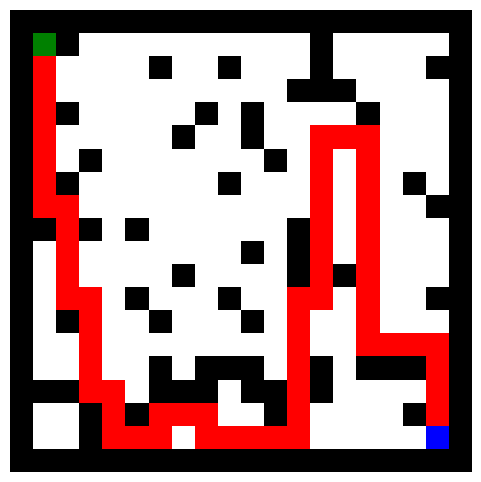

In [4]:
# Run DFS
dfs_metrics = dfs(w, start, goal)

### Breadth-First Search (BFS)

Breadth-First Search (BFS) is an algorithm used for traversing or searching tree or graph data structures. It explores all neighboring nodes at the current depth before moving on to nodes at the next depth level. BFS uses a queue data structure to keep track of the next nodes to visit.

In our grid environment, BFS starts at tile `(1, 1)` and explores all reachable tiles level by level. This ensures that the shortest path to the goal tile `(L - 2, H - 2)` is found, as BFS always finds the shortest path in an unweighted graph when each move has the same cost.

The implementation of BFS is similar to DFS, but it uses a queue instead of a stack to reproduce the breadth-first traversal behavior.

In [5]:
def bfs(world, s0, t):
    """
    Performs Breadth-First Search (BFS) to find the shortest path from the start tile to the target tile.

    Parameters:
        world (world): An instance of the `world` class representing the grid environment.
        s0 (int): The index of the starting tile.
        t (int): The index of the target tile.

    Returns:
        dict: A dictionary containing the search metrics, including:
            - 'found' (bool): Indicates whether a path was found.
            - 'path' (list of int): The list of tile indices representing the path from start to target.
            - 'path_length' (int): The number of tiles in the path.
            - 'cost' (float): The total cost of the path.
            - 'visited_tiles' (int): The number of tiles visited during the search.
    """
    from collections import deque

    result = False      # Result flag
    path = []           # List to store the final path
    queue = deque([s0]) # Queue for BFS (First-In, First-Out)
    visited = [False] * (world.L * world.H)  # List to keep track of visited tiles
    visited[s0] = True
    parent = {}         # Dictionary to keep track of each tile's parent
    nb_visited = 0      # Counter for visited tiles

    while queue:
        current = queue.popleft()  # Dequeue the first tile
        nb_visited += 1

        # Reconstruct the current path from start to the current tile for visualization
        current_path = []
        temp = current
        while temp != s0:
            current_path.append(temp)
            temp = parent.get(temp, s0)
        current_path.append(s0)
        current_path.reverse()

        # Visualize the current path
        clear_output(wait=True)
        world.display(current_path)

        # Check if the current tile is the target
        if current == t:
            result = True
            path = current_path
            break

        # Enqueue valid successors
        for successor in world.successors(current):
            if not visited[successor]:
                visited[successor] = True
                parent[successor] = current
                queue.append(successor)

    # Display the final path after the search is complete
    clear_output(wait=True)
    world.display(path)

    # Calculate the total cost if a path was found
    if result:
        total_cost = sum(world.costs[tile] for tile in path)
    else:
        total_cost = float('inf')

    # Compile metrics into a dictionary
    metrics = {
        'found': result,
        'path': path,
        'path_length': len(path) if result else 0,
        'cost': total_cost,
        'visited_tiles': nb_visited
    }

    return metrics

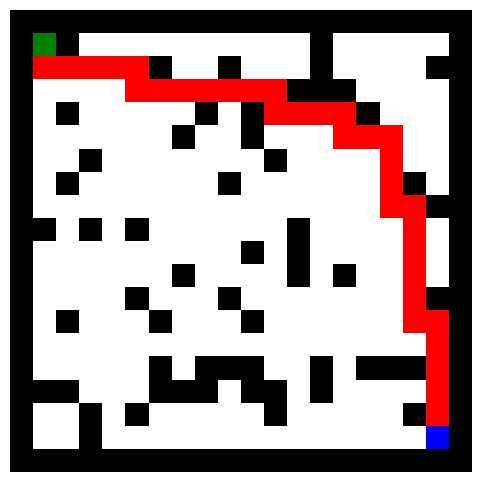

In [6]:
# Run BFS
bfs_metrics = bfs(w, start, goal)

### Analysis of DFS and BFS

After testing both DFS and BFS on different grid environments, we can make the following observations:

- **Completeness**: Both DFS and BFS are complete algorithms, meaning they will find a solution if one exists.
- **Optimality**: BFS is optimal when all moves have the same cost, as it explores nodes level by level. DFS, on the other hand, is not guaranteed to find the shortest path.
- **Space Complexity**: BFS has a higher space complexity than DFS due to the need to store all nodes at the current level. This can be a limiting factor in memory-constrained environments.
- **Time Complexity**: In the worst-case scenario, both DFS and BFS have a time complexity of `O(b^d)`, where `b` is the branching factor (the average number of children per node) and `d` is the depth of the solution. However, the actual time taken can vary based on the structure of the graph and the specific path taken.

Overall, BFS is preferred when the goal is to find the shortest path in an unweighted graph, while DFS can be useful in certain scenarios where memory constraints are a concern.

## Optimal Pathfinding

Now we want to add a positive cost to each tile, representing the distance or effort required to move from one tile to another. The agent's goal is to find the path with the lowest total cost from the start to the goal. This added cost factor is important in real-world scenarios where different paths may have different costs associated with them (e.g., for determining the fastest route on a road network).

This additional cost factor introduces a new dimension to pathfinding, as the agent must now consider both the distance to the goal and the cost of moving through each tile. This will allow more sophisticated algorithms to find the optimal path based on the total cost rather than just the number of moves.

In our case, we will assign a cost of `1` to empty tiles except for a rectangular region defined by the coordinates `(L // 3, 0)` and `(2L // 3, H - 1)`, where the cost is a constant `c > 1`. This region represents a "difficult terrain" that the agent should avoid if possible.

In [7]:
# Set costs in a specific rectangle
x1, y1 = (w.L // 3), 0  # First corner of the rectangle
x2, y2 = 2 * (w.L // 3), w.H - 1  # Opposite corner of the rectangle
min_cost = 2
max_cost = 5
w.set_costs_in_rectangle(x1, y1, x2, y2, min_cost, max_cost)

### Dijkstra's Algorithm

Dijkstra's algorithm is a pathfinding algorithm used to find the shortest path between nodes in a weighted graph. Unlike DFS and BFS, which do not consider varying movement costs between nodes, Dijkstra's algorithm accounts for the cost of moving from one node to another, allowing it to find the least expensive path.

Here's how it works:

1. **Initialization**: Start at the initial node (e.g., `(1, 1)`) and assign a tentative distance (total cost) of zero to it. Set the tentative distance of all other nodes to infinity.
2. **Visit Nodes**: Select the unvisited node with the smallest tentative distance. For the initial step, this is the starting node.
3. **Update Neighbors**: For each unvisited neighbor of the current node, calculate the tentative distance through the current node. If this distance is less than their current tentative distance, update it.
4. **Mark Visited**: Once all neighbors are considered, mark the current node as visited. A visited node will not be checked again.
5. **Repeat**: Continue steps 2–4 until the target node `(L - 2, H - 2)` is marked visited or all reachable nodes have been visited.
6. **Reconstruct Path**: Backtrack from the target node to the start node using the recorded paths to reconstruct the shortest path.

In [8]:
def dijkstra(world, s0, t):
    """
    Performs Dijkstra's Algorithm to find the shortest path from the start tile to the target tile.

    Parameters:
        world (world): An instance of the `world` class representing the grid environment.
        s0 (int): The index of the starting tile.
        t (int): The index of the target tile.

    Returns:
        dict: A dictionary containing the search metrics, including:
            - 'found' (bool): Indicates whether a path was found.
            - 'path' (list of int): The list of tile indices representing the path from start to target.
            - 'path_length' (int): The number of tiles in the path.
            - 'cost' (float): The total cost of the path.
            - 'visited_tiles' (int): The number of tiles visited during the search.
    """
    import heapq

    result = False                                   # Result flag
    path = []                                        # List to store the final path
    distance = [float('inf')] * (world.L * world.H)  # Distance from start to each tile
    visited = [False] * (world.L * world.H)          # Visited tiles
    parent = {}                                      # Parent tiles to reconstruct the path
    nb_visited = 0                                   # Counter for visited tiles

    distance[s0] = 0
    heap = [(0, s0)]  # Min-heap priority queue (distance, tile_index)

    while heap:
        current_dist, current = heapq.heappop(heap)
        if visited[current]:
            continue
        visited[current] = True
        nb_visited += 1

        # Reconstruct the current path for visualization
        current_path = []
        temp = current
        while temp != s0:
            current_path.append(temp)
            temp = parent.get(temp, s0)
        current_path.append(s0)
        current_path.reverse()

        # Visualize the current path
        clear_output(wait=True)
        world.display(current_path)

        # Check if the current tile is the target
        if current == t:
            result = True
            path = current_path
            break

        # Update distances to successors
        for successor in world.successors(current):
            if not visited[successor]:
                new_dist = distance[current] + world.costs[successor]
                if new_dist < distance[successor]:
                    distance[successor] = new_dist
                    parent[successor] = current
                    heapq.heappush(heap, (new_dist, successor))

    # Display the final path
    clear_output(wait=True)
    world.display(path, display_costs=True)

    # Compile metrics into a dictionary
    metrics = {
        'found': result,
        'path': path,
        'path_length': len(path) if result else 0,
        'cost': distance[t] if result else float('inf'),
        'visited_tiles': nb_visited
    }

    # Display metrics
    print(f"Path Found: {metrics['found']}")
    if metrics['found']:
        print(f"Path Length: {metrics['path_length']}")
        print(f"Total Cost: {metrics['cost']}")
    print(f"Number of Visited Tiles: {metrics['visited_tiles']}")
    if metrics['found']:
        print(f"Path: {metrics['path']}")

    return metrics

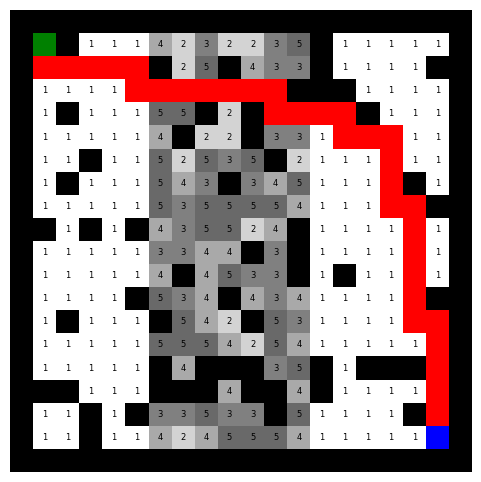

Path Found: True
Path Length: 35
Total Cost: 54
Number of Visited Tiles: 261
Path: [21, 41, 42, 43, 44, 45, 65, 66, 67, 68, 69, 70, 71, 91, 92, 93, 94, 114, 115, 116, 136, 156, 176, 177, 197, 217, 237, 257, 277, 278, 298, 318, 338, 358, 378]


In [21]:
# Run Dijkstra's algorithm
dijkstra_metrics = dijkstra(w, start, goal)

In order to see the effect of taking into account the cost of moving between tiles, we will compare the results of Dijkstra's algorithm with the previous algorithms (DFS and BFS) on the same grid environment. We expect Dijkstra's algorithm to find the optimal path based on the total cost, which may differ from the shortest path in terms of the number of moves.

Let's rerun DFS and BFS on the same grid environment but with the added cost factor, and then compare the results with Dijkstra's algorithm.

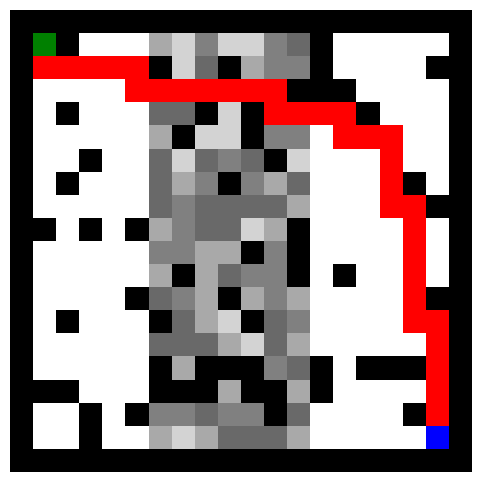

In [10]:
dfs_cost_metrics = dfs(w, start, goal)
bfs_cost_metrics = bfs(w, start, goal)

In [11]:
# Display path length, total cost, and number of visited tiles for each algorithm
print("DFS Metrics:")
print(f"Path Length: {dfs_cost_metrics['path_length']}")
print(f"Total Cost: {dfs_cost_metrics['cost']}")
print(f"Visited Tiles: {dfs_cost_metrics['visited_tiles']}")
print("\nBFS Metrics:")
print(f"Path Length: {bfs_cost_metrics['path_length']}")
print(f"Total Cost: {bfs_cost_metrics['cost']}")
print(f"Visited Tiles: {bfs_cost_metrics['visited_tiles']}")
print("\nDijkstra's Metrics:")
print(f"Path Length: {dijkstra_metrics['path_length']}")
print(f"Total Cost: {dijkstra_metrics['cost']}")
print(f"Visited Tiles: {dijkstra_metrics['visited_tiles']}")

DFS Metrics:
Path Length: 63
Total Cost: 111
Visited Tiles: 178

BFS Metrics:
Path Length: 35
Total Cost: 55
Visited Tiles: 263

Dijkstra's Metrics:
Path Length: 35
Total Cost: 54
Visited Tiles: 261


As expected, even if the path length can be the same (or very similar), the total cost of the path found by Dijkstra's algorithm is lower than the one found by BFS or DFS. This proves the optimality of Dijkstra's algorithm in finding the path with the lowest total cost and therefore adapting to a real-world scenario where different paths have different costs associated with them.

### A* Algorithm

#### Algorithm Overview

Although **Dijkstra's algorithm** is effective at finding the optimal path based on total cost, it can be computationally expensive when exploring large graphs due to its exhaustive search approach. Dijkstra's algorithm explores all possible paths from the start node to the goal node, even those unlikely to be part of the optimal path, such as paths moving away from the goal.

The **A\* algorithm** is an extension of Dijkstra's algorithm that uses a heuristic function to guide the search more efficiently toward the goal node. A heuristic estimates the cost of the cheapest path from the current node to the goal node. 

In the A\* algorithm, each node is assigned a cost `f(n) = g(n) + h(n)`, where:
- `g(n)` is the actual cost of the path from the start node to node `n`.
- `h(n)` is the heuristic estimate of the cost from node `n` to the goal node.

The A\* algorithm selects the node with the lowest `f(n)` value for exploration, prioritizing nodes that are closer to the goal. 

#### Heuristic Function in a Grid Environment

In our case, we will use the **Manhattan distance** (also known as the L1 norm) as the heuristic, which calculates the distance between two points by summing the absolute differences of their coordinates (ignoring obstacles). For a 20×20 grid with the start at `(1, 1)` and the goal at `(18, 18)`, the Manhattan distance is:

$$
h = |18 - 1| + |18 - 1| = 34
$$

Let's implement the A\* algorithm with this heuristic and compare its performance with Dijkstra's algorithm on the same grid environment.

In [17]:
def astar(world, s0, t):
    """
    Performs the A* Search Algorithm to find the shortest path from the start tile to the goal tile.

    Parameters:
        world (world): An instance of the `world` class representing the grid environment.
        s0 (int): The index of the starting tile.
        t (int): The index of the target (goal) tile.

    Returns:
        dict: A dictionary containing the search metrics, including:
            - 'found' (bool): Indicates whether a path was found.
            - 'path' (list of int): The list of tile indices representing the path from start to goal.
            - 'path_length' (int): The number of tiles in the path.
            - 'cost': The total cost of the path.
            - 'visited_tiles': The number of tiles visited during the search.
    """
    import heapq

    # Initialize open and closed sets
    open_set = [] # The open set contains the nodes to be evaluated, with their f_score
    heapq.heappush(open_set, (0, s0))
    closed_set = set() # The closed set contains the nodes already evaluated

    # Initialize g_score and f_score dictionaries for each node with infinity as default value
    g_score = {i: float('inf') for i in range(world.L * world.H)} 
    g_score[s0] = 0

    f_score = {i: float('inf') for i in range(world.L * world.H)}
    f_score[s0] = heuristic(s0, t, world)

    # Parent dictionary to reconstruct the path
    parent = {}

    nb_visited = 0  # Counter for visited tiles

    while open_set:
        # Pop the node with the lowest f_score
        current_f_score, current = heapq.heappop(open_set)
        nb_visited += 1

        # Visualize the current path
        current_path = []
        temp = current
        while temp in parent:
            current_path.append(temp)
            temp = parent[temp]
        current_path.append(s0)
        current_path.reverse()

        clear_output(wait=True)
        world.display(current_path)

        # Check if we have reached the goal
        if current == t:
            # Reconstruct the final path
            path = current_path

            # Calculate total cost
            total_cost = g_score[t]

            # Compile metrics into a dictionary
            metrics = {
                'found': True,
                'path': path,
                'path_length': len(path),
                'cost': total_cost,
                'visited_tiles': nb_visited
            }

            # Display the final path
            clear_output(wait=True)
            world.display(path, display_costs=True)
            
            # Display metrics
            print(f"Path Found: {metrics['found']}")
            if metrics['found']:
                print(f"Path Length: {metrics['path_length']}")
                print(f"Total Cost: {metrics['cost']}")
            print(f"Number of Visited Tiles: {metrics['visited_tiles']}")
            if metrics['found']:
                print(f"Path: {metrics['path']}")

            return metrics

        closed_set.add(current)

        # Examine neighbors
        for neighbor in world.successors(current):
            if neighbor in closed_set:
                continue  # Ignore the neighbor which is already evaluated


            tentative_g_score = g_score[current] + world.costs[neighbor]

            # If the path to get to the neighbor is shorter than a previous one, update the parent and scores
            if tentative_g_score < g_score[neighbor]:
                parent[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, t, world)

                # If neighbor is not in open_set, add it
                if not any(neighbor == item[1] for item in open_set):
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    # If open_set is empty but goal was never reached
    metrics = {
        'found': False,
        'path': [],
        'path_length': 0,
        'cost': float('inf'),
        'visited_tiles': nb_visited
    }

    # Display that no path was found
    clear_output(wait=True)
    world.display(display_costs=True)
    print("No path found.")

    return metrics

def heuristic(current, goal, world):
    """
    Calculates an admissible heuristic using the Manhattan distance.

    Parameters:
        world (world): The grid environment.
        current (int): The index of the current tile.
        goal (int): The index of the goal tile.

    Returns:
        float: The estimated minimal cost from current to goal.
    """
    # Convert tile indices to (x, y) coordinates
    L = world.L
    x1, y1 = current % L, current // L 
    x2, y2 = goal % L, goal // L

    # Minimal possible movement cost
    min_cost = 1

    # Calculate Manhattan distance
    manhattan_distance = abs(x1 - x2) + abs(y1 - y2)

    # Estimated minimal cost
    estimated_cost = min_cost * manhattan_distance

    return estimated_cost


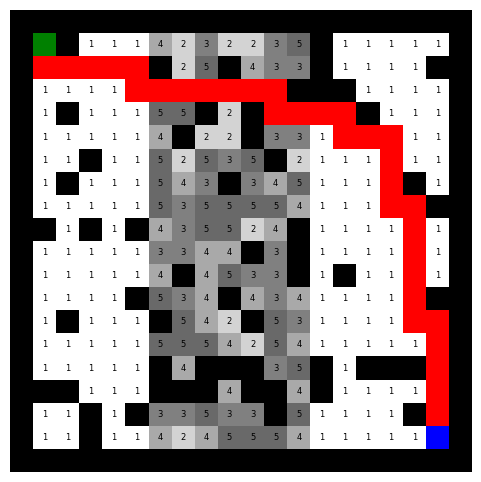

Path Found: True
Path Length: 35
Total Cost: 54
Number of Visited Tiles: 230
Path: [21, 41, 42, 43, 44, 45, 65, 66, 67, 68, 69, 70, 71, 91, 92, 93, 94, 114, 115, 116, 136, 156, 176, 177, 197, 217, 237, 257, 277, 278, 298, 318, 338, 358, 378]


In [20]:
# Run A* search
astar_metrics = astar(w, start, goal)

The A\* algorithm is a significant improvement over Dijkstra's algorithm in terms of efficiency. By visualizing the search process, we can see how A\* quickly converges to the optimal path by prioritizing nodes closer to the goal. This behavior is especially beneficial in large graphs or environments with varying movement costs, where exploring all possible paths exhaustively can be computationally expensive.

A worthwhile approach would be to modify the heuristic function to better align with the environment's specific characteristics, such as the presence of walls or challenging terrain. This adaptation can enhance the efficiency of the A* algorithm by providing more accurate cost estimates for reaching the goal.